## Proyecto

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sb
from sklearn.utils import resample

In [1651]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn import tree
from sklearn import svm
from joblib import dump
from scipy.special import softmax
from scipy import stats
import random

In [8]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


### Carga de datos

In [968]:
base_data = pd.read_csv('github/data_titanic_proyecto.csv')

In [969]:
base_data

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,S,Middle,M,N
887,888,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,S,Upper,F,Y
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,S,Lower,F,N
889,890,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,C,Upper,M,Y


### Feature Engineering

In [970]:
base_data.describe()

,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200


In [971]:
explore = base_data

In [972]:
## llenado de vacios de edad
edad_media =explore.Age.median( skipna = True)
explore.Age = explore.Age.replace(np.NaN,edad_media)

In [973]:
## llenando vacios de Embarked

#explore.Embarked.value_counts()

explore.Embarked = explore.Embarked.replace(np.NaN,'S')

#explore.Embarked.value_counts()
explore.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [974]:
# one hot enconde de clase
#temp = pd.get_dummies(base_data['passenger_class'], prefix='Clase')

#np.unique(base_data['passenger_class'])

explore['Embarked'] = pd.factorize(explore['Embarked'])[0]

# conversion a numeros de la clase
explore['passenger_class'] = pd.factorize(explore['passenger_class'])[0]

# conversion de sexo a numero
explore['passenger_sex'] = pd.factorize(explore['passenger_sex'])[0]

explore['survived'] = pd.factorize(explore['passenger_survived'])[0]

explore['cat_edad'] = pd.cut(explore.Age,bins=[0,5,15,55,99], right=False,labels=['Baby','Child','Adult','Elderly'])

explore['cat_edad'] = pd.factorize(explore['cat_edad'])[0]

explore

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived,survived,cat_edad
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,0,0,N,0,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,1,Y,1,0
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,Y,1,0
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,1,1,Y,1,0
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,0,0,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,0,2,0,N,0,0
887,888,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,0,1,1,Y,1,0
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",28.0,1,2,W./C. 6607,23.4500,NaN,0,0,1,N,0,0
889,890,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,1,1,0,Y,1,0


Se remueven las columnas que no se consideran relevantes

In [774]:
explore[explore.cat_edad==1]

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived,survived,cat_edad
7,2.0,3,1,21.0750,0,0,0,N,0,1
9,14.0,1,0,30.0708,1,2,1,Y,1,1
10,4.0,1,1,16.7000,0,0,1,Y,1,1
14,14.0,0,0,7.8542,0,0,1,N,0,1
16,2.0,4,1,29.1250,2,0,0,N,0,1
...,...,...,...,...,...,...,...,...,...,...
850,4.0,4,2,31.2750,0,0,0,N,0,1
852,9.0,1,1,15.2458,1,0,1,N,0,1
853,16.0,0,1,39.4000,0,1,1,Y,1,1
869,4.0,1,1,11.1333,0,0,0,Y,1,1


In [975]:
del explore["PassengerId"]
del explore["Name"]
del explore["Ticket"]
del explore["Cabin"]
#del explore["passenger_survived"]


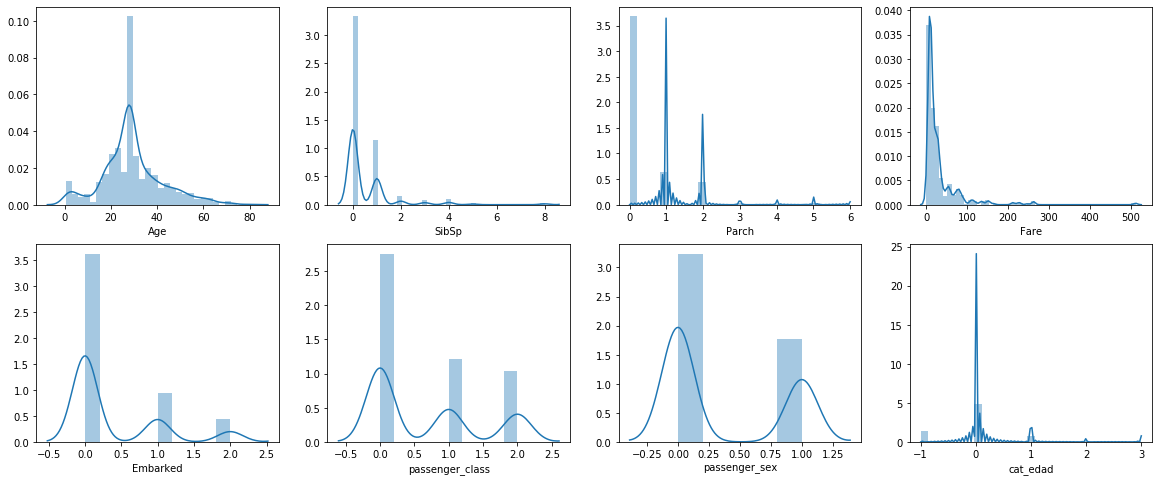

In [719]:
edad = explore.dropna(subset=['Age'])
f, axes = plt.subplots(2, 4, figsize=(20, 8))
sb.distplot( edad['Age'], ax=axes[0, 0])
sb.distplot( explore["SibSp"] , ax=axes[0, 1])
sb.distplot( explore["Parch"] , ax=axes[0, 2])
sb.distplot( explore["Fare"] , ax=axes[0, 3])
sb.distplot( explore["Embarked"] , ax=axes[1, 0])
sb.distplot( explore["passenger_class"] , ax=axes[1, 1])
sb.distplot( explore["passenger_sex"] , ax=axes[1, 2])
sb.distplot( explore["cat_edad"] , ax=axes[1, 3])

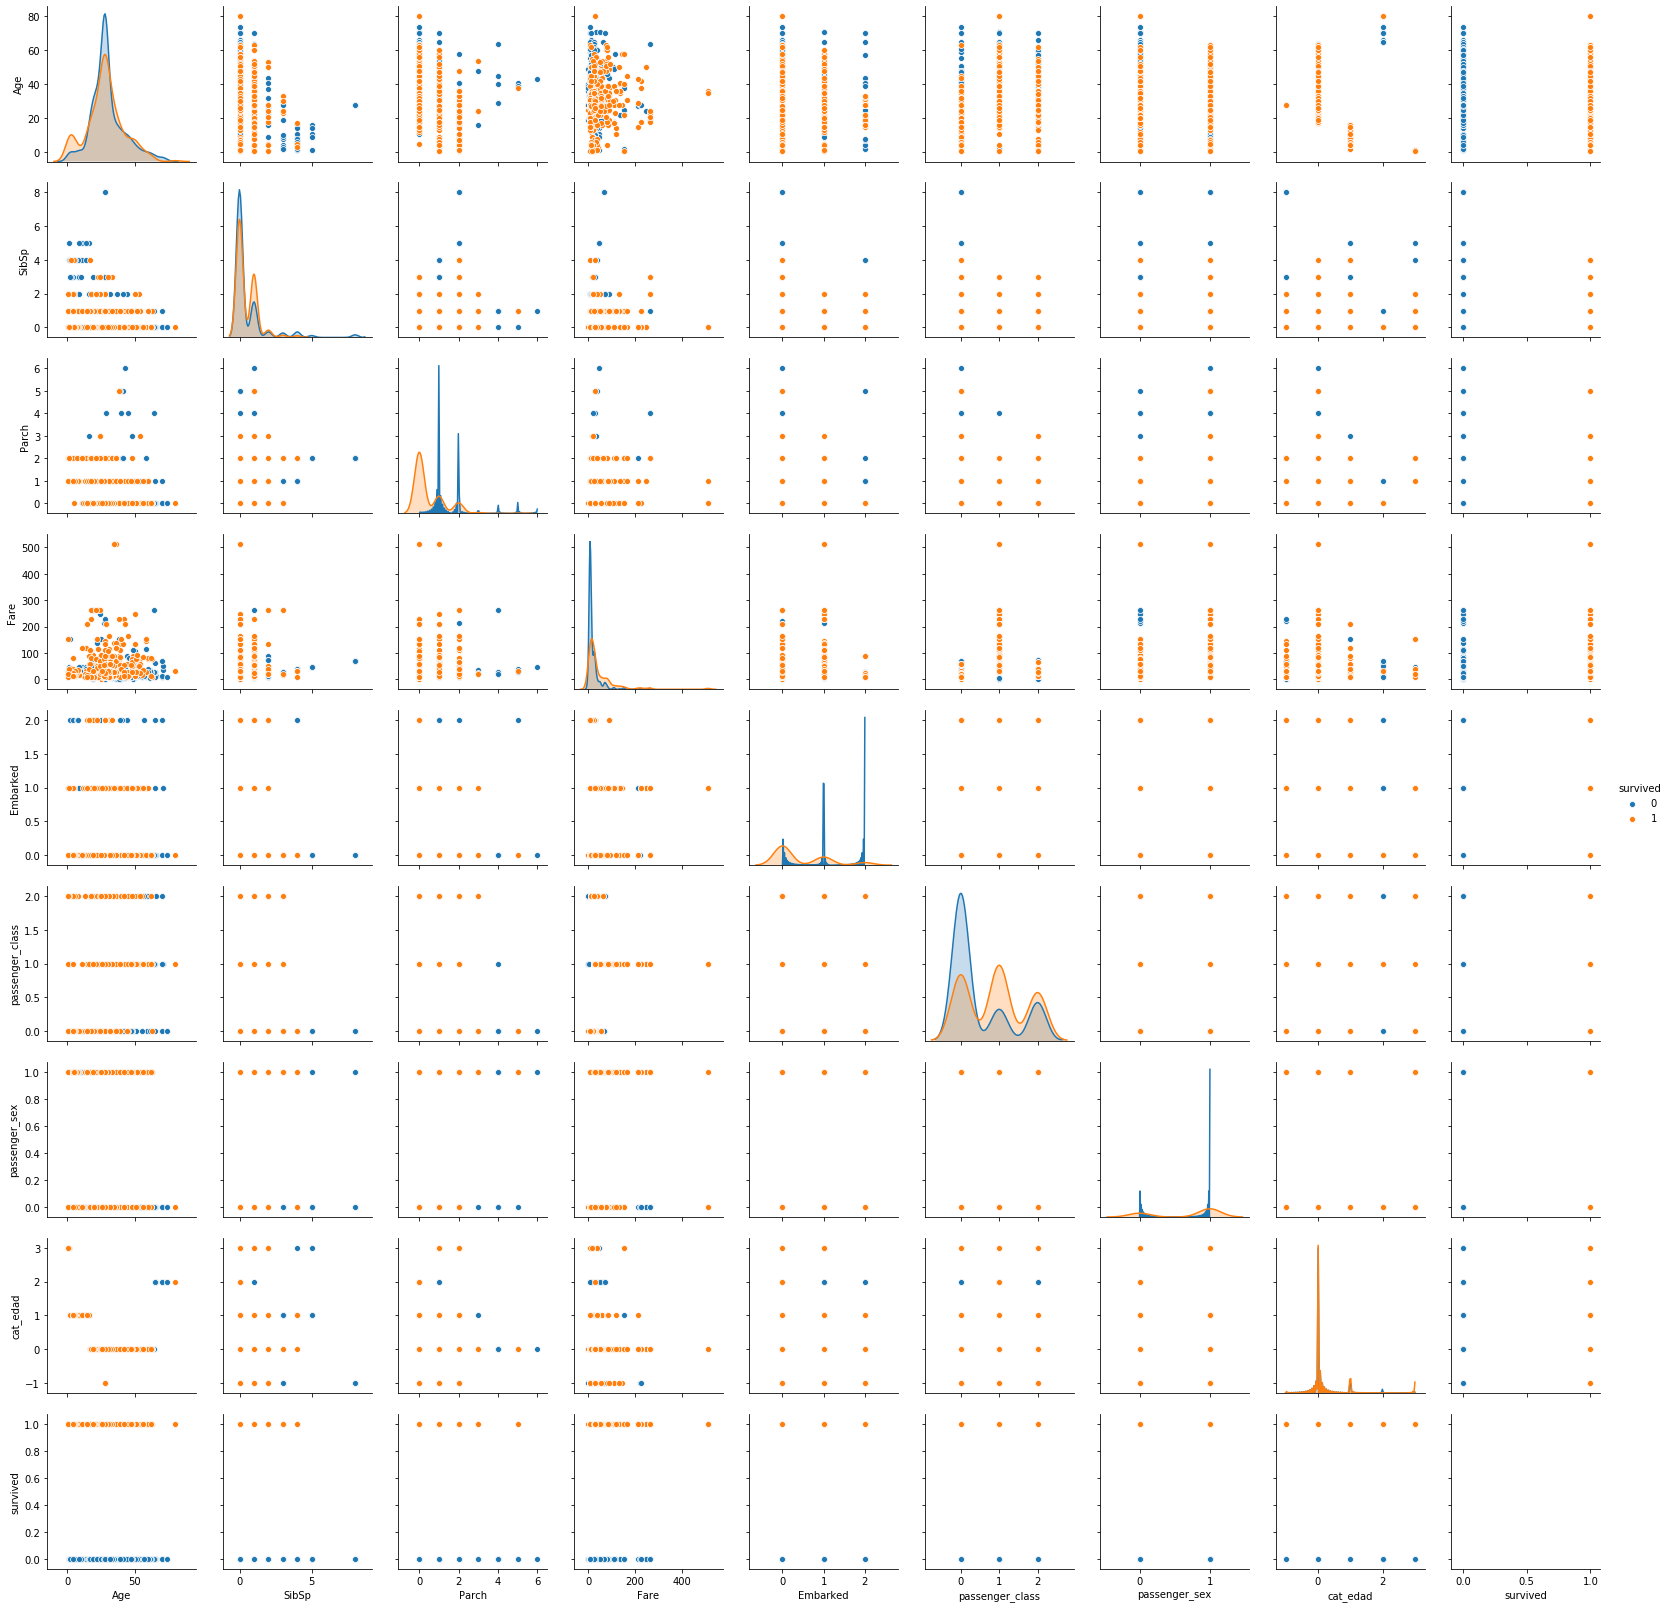

In [720]:
sb.pairplot(explore, hue="survived", height=2.5);

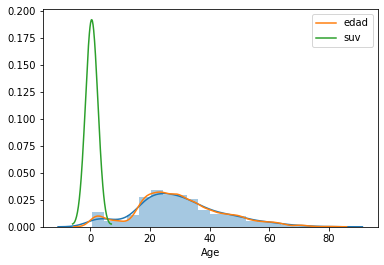

In [580]:
ax = sb.distplot(edad["Age"])
sb.kdeplot(edad["Age"], bw=2, label="edad")
sb.kdeplot(edad["survived"], bw=2, label="suv")
plt.legend();

In [608]:
#Embarked
cof_mat = np.corrcoef([explore["Age"],explore["SibSp"],explore["Parch"],explore["Fare"],explore["passenger_class"],
                       explore["Embarked"],explore["passenger_sex"],explore["cat_edad"]],explore["survived"])
coef = cof_mat[6:][0]     
print(coef)

[       nan 0.11463081 0.24548896 0.18233283 0.11813327 0.11124902
 1.         0.04559044 0.54335138]


In [1789]:
#base_data.values
nrz = explore[["Age","SibSp","Parch","Fare","Embarked","passenger_class","passenger_sex","survived","cat_edad"]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(nrz)
new_data = pd.DataFrame(x_scaled)
new_data 


,0,1,2,3,4,5,6,7,8
0,0.271174,0.125,0.000000,0.014151,0.0,0.0,0.0,0.0,0.0
1,0.472229,0.125,0.000000,0.139136,0.5,0.5,1.0,1.0,0.0
2,0.321438,0.000,0.000000,0.015469,0.0,0.0,1.0,1.0,0.0
3,0.434531,0.125,0.000000,0.103644,0.0,0.5,1.0,1.0,0.0
4,0.434531,0.000,0.000000,0.015713,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
886,0.334004,0.000,0.000000,0.025374,0.0,1.0,0.0,0.0,0.0
887,0.233476,0.000,0.000000,0.058556,0.0,0.5,1.0,1.0,0.0
888,0.346569,0.125,0.333333,0.045771,0.0,0.0,1.0,0.0,0.0
889,0.321438,0.000,0.000000,0.058556,0.5,0.5,0.0,1.0,0.0


In [1790]:
new_data.columns = ["Age","SibSp","Parch","Fare","Embarked","passenger_class","passenger_sex","survived","cat_edad"]

In [1791]:
new_data

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,survived,cat_edad
0,0.271174,0.125,0.000000,0.014151,0.0,0.0,0.0,0.0,0.0
1,0.472229,0.125,0.000000,0.139136,0.5,0.5,1.0,1.0,0.0
2,0.321438,0.000,0.000000,0.015469,0.0,0.0,1.0,1.0,0.0
3,0.434531,0.125,0.000000,0.103644,0.0,0.5,1.0,1.0,0.0
4,0.434531,0.000,0.000000,0.015713,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
886,0.334004,0.000,0.000000,0.025374,0.0,1.0,0.0,0.0,0.0
887,0.233476,0.000,0.000000,0.058556,0.0,0.5,1.0,1.0,0.0
888,0.346569,0.125,0.333333,0.045771,0.0,0.0,1.0,0.0,0.0
889,0.321438,0.000,0.000000,0.058556,0.5,0.5,0.0,1.0,0.0


##### Escaldo de Age y Fare

In [1825]:

explore['Age'] = (explore['Age'] - min(explore['Age']))/ (max(explore['Age'])-min(explore['Age']))
explore['Fare'] = (explore['Fare'] - min(explore['Fare']))/ (max(explore['Fare'])-min(explore['Fare']))

### Bootstrap de los datos

Los datos se separaran en

 * Pruebas 20% = x#p, y#p
 * Validacion 20% = x#v, y#v
 * Entrenamiento 60% = x#e, y#e

Para cada modelo a utilizar se crean un set de datos independiente por lo cual se le pone un **random_state** diferente a cada uno y tener el mismo resultado en los grupos cada vez que se corre el segmento de codigo

In [1826]:
Y = explore[['survived']]
X = explore[['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex','cat_edad','survived']]

In [1827]:
x1, x1p, y1, y1p = train_test_split(X, Y, test_size=0.2, random_state=100, shuffle= True)
x2, x2p, y2, y2p = train_test_split(X, Y, test_size=0.2, random_state=101, shuffle= True)
x3, x3p, y3, y3p = train_test_split(X, Y, test_size=0.2, random_state=102, shuffle= True)
x4, x4p, y4, y4p = train_test_split(X, Y, test_size=0.2, random_state=103, shuffle= True)

# del 80% de datos el paso anterior se separa en 75% para tener el 60% del total
x1e, x1v, y1e, y1v = train_test_split(x1, y1, test_size=0.25, random_state=100, shuffle= True)
x2e, x2v, y2e, y2v = train_test_split(x1, y1, test_size=0.25, random_state=101, shuffle= True)
x3e, x3v, y3e, y3v = train_test_split(x1, y1, test_size=0.25, random_state=102, shuffle= True)
x4e, x4v, y4e, y4v = train_test_split(x1, y1, test_size=0.25, random_state=103, shuffle= True)



In [1828]:
x3e

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,cat_edad,survived
504,0.195778,0,0,0.168837,0,1,1,0,1
199,0.296306,0,0,0.025374,0,2,1,0,0
831,0.005152,1,1,0.036598,0,2,0,1,1
737,0.434531,0,0,1.000000,1,1,0,0,1
431,0.346569,1,0,0.031425,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
856,0.560191,1,1,0.321798,0,1,1,0,1
495,0.346569,0,0,0.028221,1,0,0,0,0
230,0.434531,1,0,0.162932,0,1,1,0,1
628,0.321438,0,0,0.015412,0,0,0,0,0


Asignacion de datos:

    1 Árbol de decisión con sklearn
    2 SVM con sklearn
    3 Naive bayes con numpy y/o pandas
    4 Reg. logística binaria(sigmoid)  

### Naive Bayes

#### Generador de modelo NB

In [1583]:
def NB(x):
    total = len(x)
    s_t = x.survived.value_counts()
    #print(s_t)
    #print(total)
    tn,ts= s_t[0]/total,s_t[1]/total
    #print(tn,ts)
    
    # sexo 
    s_p=x.groupby(['survived','passenger_sex']).count()
    # p(Male|No)     p(~Male|No)
    an1 = np.array([s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0]])
    # p(~Female|No)  p(Female|No) 
    an2 = np.array([1-s_p['Fare'][0][1]/s_t[0],s_p['Fare'][0][1]/s_t[0]])
    # p(Male|Yes)     p(~Male|Yes)
    as1 = np.array([s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1]])
    # p(Female|Yes)     p(~Female|Yes)
    as2 = np.array([1-s_p['Fare'][1][1]/s_t[1],s_p['Fare'][1][1]/s_t[1]])
    
    # Clase
    s_p=x.groupby(['survived','passenger_class']).count()
    # p(Lower|No)     p(~Lower|No)     p(~Lower|No)
    cn1 = np.array([s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0]])
    # p(~Upper|No)    p(Upper|No)      p(~Upper|No) 
    cn2 = np.array([1-s_p['Fare'][0][1]/s_t[0],s_p['Fare'][0][1]/s_t[0],1-s_p['Fare'][0][1]/s_t[0]])
    # p(Middle|No)    p(Middle|No)      p(~Middle|No) 
    cn3 = np.array([1-s_p['Fare'][0][2]/s_t[0],1-s_p['Fare'][0][2]/s_t[0],s_p['Fare'][0][2]/s_t[0]])

    # p(Lower|Yes)     p(~Lower|Yes)     p(~Lower|Yes)
    cs1 = np.array([s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1]])
    # p(~Upper|Yes)    p(Upper|Yes)      p(~Upper|Yes) 
    cs2 = np.array([1-s_p['Fare'][1][1]/s_t[1],s_p['Fare'][1][1]/s_t[1],1-s_p['Fare'][1][1]/s_t[1]])
    # p(Middle|Yes)    p(Middle|Yes)      p(~Middle|Yes) 
    cs3 = np.array([1-s_p['Fare'][1][2]/s_t[1],1-s_p['Fare'][1][2]/s_t[1],s_p['Fare'][1][2]/s_t[1]])

    # Embarked
    s_p=x.groupby(['survived','Embarked']).count()
    # p(0|No)     p(~0|No)     p(~0|No)       p(~0|No)
    en1 = np.array([s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0]])
    # p(~0|No)    p(0|No)      p(~0|No)     p(~0|No)
    en2 = np.array([1-s_p['Fare'][0][1]/s_t[0],s_p['Fare'][0][1]/s_t[0],1-s_p['Fare'][0][1]/s_t[0],1-s_p['Fare'][0][1]/s_t[0]])
    # p(~0|No)    p(~0|No)      p(0|No)     p(~0|No) 
    en3 = np.array([1-s_p['Fare'][0][2]/s_t[0],1-s_p['Fare'][0][2]/s_t[0],s_p['Fare'][0][2]/s_t[0],1-s_p['Fare'][0][2]/s_t[0]])
    # p(0|No)    p(~0|No)      p(~0|No)      p(0|No) 
    #en4 = np.array([1-s_p['Fare'][0][3]/s_t[0],1-s_p['Fare'][0][3]/s_t[0],1-s_p['Fare'][0][3]/s_t[0],s_p['Fare'][0][3]/s_t[0]])

    # p(Lower|Yes)     p(~Lower|Yes)     p(~Lower|Yes)
    es1 = np.array([s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1]])
    # p(~Upper|Yes)    p(Upper|Yes)      p(~Upper|Yes) 
    es2 = np.array([1-s_p['Fare'][1][1]/s_t[1],s_p['Fare'][1][1]/s_t[1],1-s_p['Fare'][1][1]/s_t[1],1-s_p['Fare'][1][1]/s_t[1]])
    # p(Middle|Yes)    p(Middle|Yes)      p(~Middle|Yes) 
    es3 = np.array([1-s_p['Fare'][1][2]/s_t[1],1-s_p['Fare'][1][2]/s_t[1],s_p['Fare'][1][2]/s_t[1],1-s_p['Fare'][1][2]/s_t[1]])
    #es4 = np.array([1-s_p['Fare'][1][3]/s_t[1],1-s_p['Fare'][1][3]/s_t[1],1-s_p['Fare'][1][3]/s_t[1],s_p['Fare'][1][3]/s_t[1]])

    # Edad
    s_p=x.groupby(['survived','cat_edad']).count()
    # p(0|No)     p(~0|No)     p(~0|No)       p(~0|No)
    if (0,0) in s_p['Fare'].index:
        gn1 = np.array([s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0],1-s_p['Fare'][0][0]/s_t[0]])
    else:
        gn1 = np.array([1,1,1,1]) #([1/total,1/total,1/total,1/total])
    # p(~0|No)    p(0|No)      p(~0|No)     p(~0|No)
    if (0,1) in s_p['Fare'].index:
        gn2 = np.array([1-s_p['Fare'][0][1]/s_t[0],s_p['Fare'][0][1]/s_t[0],1-s_p['Fare'][0][1]/s_t[0],1-s_p['Fare'][0][1]/s_t[0]])
    else:
        gn2 = np.array([1,1,1,1]) #([1/total,1/total,1/total,1/total])
    # p(~0|No)    p(~0|No)      p(0|No)     p(~0|No) 

    if (0,2) in s_p['Fare'].index:
        gn3 = np.array([1-s_p['Fare'][0][2]/s_t[0],1-s_p['Fare'][0][2]/s_t[0],s_p['Fare'][0][2]/s_t[0],1-s_p['Fare'][0][2]/s_t[0]])
    else:
        gn3 = np.array([1,1,1,1]) #([1/total,1/total,1/total,1/total])

    # p(0|No)    p(~0|No)      p(~0|No)      p(0|No) 
    if (0,3) in s_p['Fare'].index:
        gn4 = np.array([1-s_p['Fare'][0][3]/s_t[0],1-s_p['Fare'][0][3]/s_t[0],1-s_p['Fare'][0][3]/s_t[0],s_p['Fare'][0][3]/s_t[0]])
    else:
        gn4 = np.array([1,1,1,1]) #([1/total,1/total,1/total,1/total])

    # p(Lower|Yes)     p(~Lower|Yes)     p(~Lower|Yes)
    if (1,0) in s_p['Fare'].index:
        gs1 = np.array([s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1],1-s_p['Fare'][1][0]/s_t[1]])
    else:
        gs1 = np.array([1,1,1,1]) #([1/total,1/total,1/total,1/total])

    # p(~Upper|Yes)    p(Upper|Yes)      p(~Upper|Yes) 
    if (1,1) in s_p['Fare'].index:
        gs2 = np.array([1-s_p['Fare'][1][1]/s_t[1],s_p['Fare'][1][1]/s_t[1],1-s_p['Fare'][1][1]/s_t[1],1-s_p['Fare'][1][1]/s_t[1]])
    else:
        gs2 = np.array([1,1,1,1]) #([1/total,1/total,1/total,1/total])

    # p(Middle|Yes)    p(Middle|Yes)      p(~Middle|Yes) 
    if (1,2) in s_p['Fare'].index:
        gs3 = np.array([1-s_p['Fare'][1][2]/s_t[1],1-s_p['Fare'][1][2]/s_t[1],s_p['Fare'][1][2]/s_t[1],1-s_p['Fare'][1][2]/s_t[1]])
    else:
        gs3 = np.array([1,1,1,1]) #([1/total,1/total,1/total,1/total])

    if (1,3) in s_p['Fare'].index:
        gs4 = np.array([1-s_p['Fare'][1][3]/s_t[1],1-s_p['Fare'][1][3]/s_t[1],1-s_p['Fare'][1][3]/s_t[1],s_p['Fare'][1][3]/s_t[1]])
    else:
        gs4 = np.array([1,1,1,1]) #([1/total,1/total,1/total,1/total])


    salida = {'sexo':(as1,as2,an1,an2),
              'clase':(cs1,cs2,cs3,cn1,cn2,cn3),
              'emb':(es1,es2,es3,en1,en2,en3),
              'edad':(gs1,gs2,gs3,gs4,gn1,gn2,gn3,gn4),
              'totales':(ts,tn),
             }
    
    return salida

#### Evaluacion de datos y resultado

In [1584]:
class NB_predict:
    def __init__(self,modelo):
        self.modelo = modelo

    
    def predict(self,data,sexo=True, clase= True, emb= True, edad=True):
        a=data[['passenger_sex','passenger_class','Embarked','cat_edad']].to_numpy()
        val_sex_s = np.array([1])
        val_sex_n = np.array([1])

        val_clas_s = np.array([1])
        val_clas_n = np.array([1])

        val_emb_s = np.array([1])
        val_emb_n = np.array([1])

        val_edad_s = np.array([1])
        val_edad_n = np.array([1])

        if sexo:
            #print()
            val_sex_s = self.modelo['sexo'][0][a[:,0]] * self.modelo['sexo'][1][a[:,0]]
            val_sex_n = self.modelo['sexo'][2][a[:,0]] * self.modelo['sexo'][3][a[:,0]]

        if clase:
            val_clas_s = self.modelo['clase'][0][a[:,1]] * self.modelo['clase'][1][a[:,1]] * self.modelo['clase'][2][a[:,1]]
            val_clas_n = self.modelo['clase'][3][a[:,1]] * self.modelo['clase'][4][a[:,1]] * self.modelo['clase'][5][a[:,1]]

        if emb:
            val_emb_s = self.modelo['emb'][0][a[:,2]] * self.modelo['emb'][1][a[:,2]] * self.modelo['emb'][2][a[:,2]] 
            val_emb_n = self.modelo['emb'][3][a[:,2]] * self.modelo['emb'][4][a[:,2]] * self.modelo['emb'][5][a[:,2]]

        if edad:
            val_edad_s = self.modelo['edad'][0][a[:,3]] * self.modelo['edad'][1][a[:,3]] * self.modelo['edad'][2][a[:,3]] * self.modelo['edad'][3][a[:,3]]
            val_edad_n = self.modelo['edad'][4][a[:,3]] * self.modelo['edad'][4][a[:,3]] * self.modelo['edad'][5][a[:,3]] * self.modelo['edad'][6][a[:,3]]

        #print(val_sex_s , val_clas_s , val_emb_s , val_edad_s)
        salida = (val_sex_s * val_clas_s * val_emb_s * val_edad_s * self.modelo['totales'][0])/ (val_sex_n * val_clas_n * val_emb_n  * val_edad_n * self.modelo['totales'][1])
        #print(salida)
        salida = (salida>1).astype(int)

        return salida

#### Prueba del modelo

In [1829]:



fechaHora = datetime.now().strftime("%Y%m%d-%H%M%S")
modelo = pd.DataFrame({'modelo': lm_nb})

modelo.to_csv('./github/modelos_nb_' + fechaHora + '.csv', header=False)

sexo = True
clase = True
emb = True
edad = True

x3train = x3e #[feature_names]
y3train = y3e
xtest = x4v#[feature_names]
ytest = y4v


lm_nb = NB(x3train)
modeloNB = NB_predict(lm_nb)

resultadoNB = modeloNB.predict(xtest,sexo,clase, emb, edad)

tn, fp, fn, tp = confusion_matrix(ytest['survived'], resultadoNB).ravel()
print(tn, fp, fn, tp)

precision,recall, fbeta_score, _  = precision_recall_fscore_support(ytest['survived'], resultadoNB, average='micro')
print(pres,rec, fbe)

#Resultado del modelo
resultado = np.array([fechaHora,sexo,clase, emb, edad,
        tn, fp,fn,tp,
        precision,recall,fbeta_score
            ])
salida = pd.DataFrame(resultado).T
#print(salida.T)
salida.to_csv("./github/nb_salida.csv", mode='a', header=False)




93 24 17 44
0.7752808988764045 0.7752808988764045 0.7752808988764045


### Decision Trees

In [1810]:
class DTC_predict:
    def __init__(self,feature_names):
        self.modelo = None
        self.feature_names = feature_names
        
    def train(self, data,ylocal, max_depth = 20,splitter = 'best'):    
        dtc = tree.DecisionTreeClassifier(max_depth = max_depth,splitter =splitter,criterion='entropy' )
        dtc = dtc.fit(data[self.feature_names], ylocal)
        self.modelo = dtc
        return dtc
    
    def predict(self, data):
        
        return self.modelo.predict(data[self.feature_names])
        

In [1957]:
fechaHora = datetime.now().strftime("%Y%m%d-%H%M%S")

#del x1e["survived"]
x1e
#x1train = x1e['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex','cat_edad']
feature_names = ['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex']

x1train = x1e #[feature_names]
y1train = y1e
xtest = x3v#[feature_names]
ytest = y3v

maxDepth = 100
splitter = 'best'

modelo_DT = DTC_predict(feature_names)

modelo_DT.train(x1train,y1train,maxDepth,splitter)

#del x1v["survived"]
rt = modelo_DT.predict(xtest)

dump(modelo_DT.modelo, './github/dt_' + fechaHora + '_maxDepth=' + str(maxDepth) + '_splitter=' + splitter + '.joblib') 

#rt_int = rt[:,1].astype(int)
#len(rt)
#rt
tn, fp, fn, tp = confusion_matrix(ytest['survived'].to_numpy(), rt ).ravel()
print(tn, fp, fn, tp)

precision,recall, fbeta_score, _  = precision_recall_fscore_support(ytest['survived'], rt, average='macro')
print(precision,recall, fbeta_score)
#tree.plot_tree(clf) 

columnas = ",".join(feature_names)

resultado = np.array([fechaHora,maxDepth,splitter,
        tn, fp,fn,tp,
        precision,recall,fbeta_score,columnas
            ])
salida = pd.DataFrame(resultado).T
#print(salida.T)
salida.to_csv("./github/dt_salida.csv", mode='a', header=False)


100 2 9 67
0.9442228427070869 0.930985552115583 0.936002614806341


#### Arbol de decision

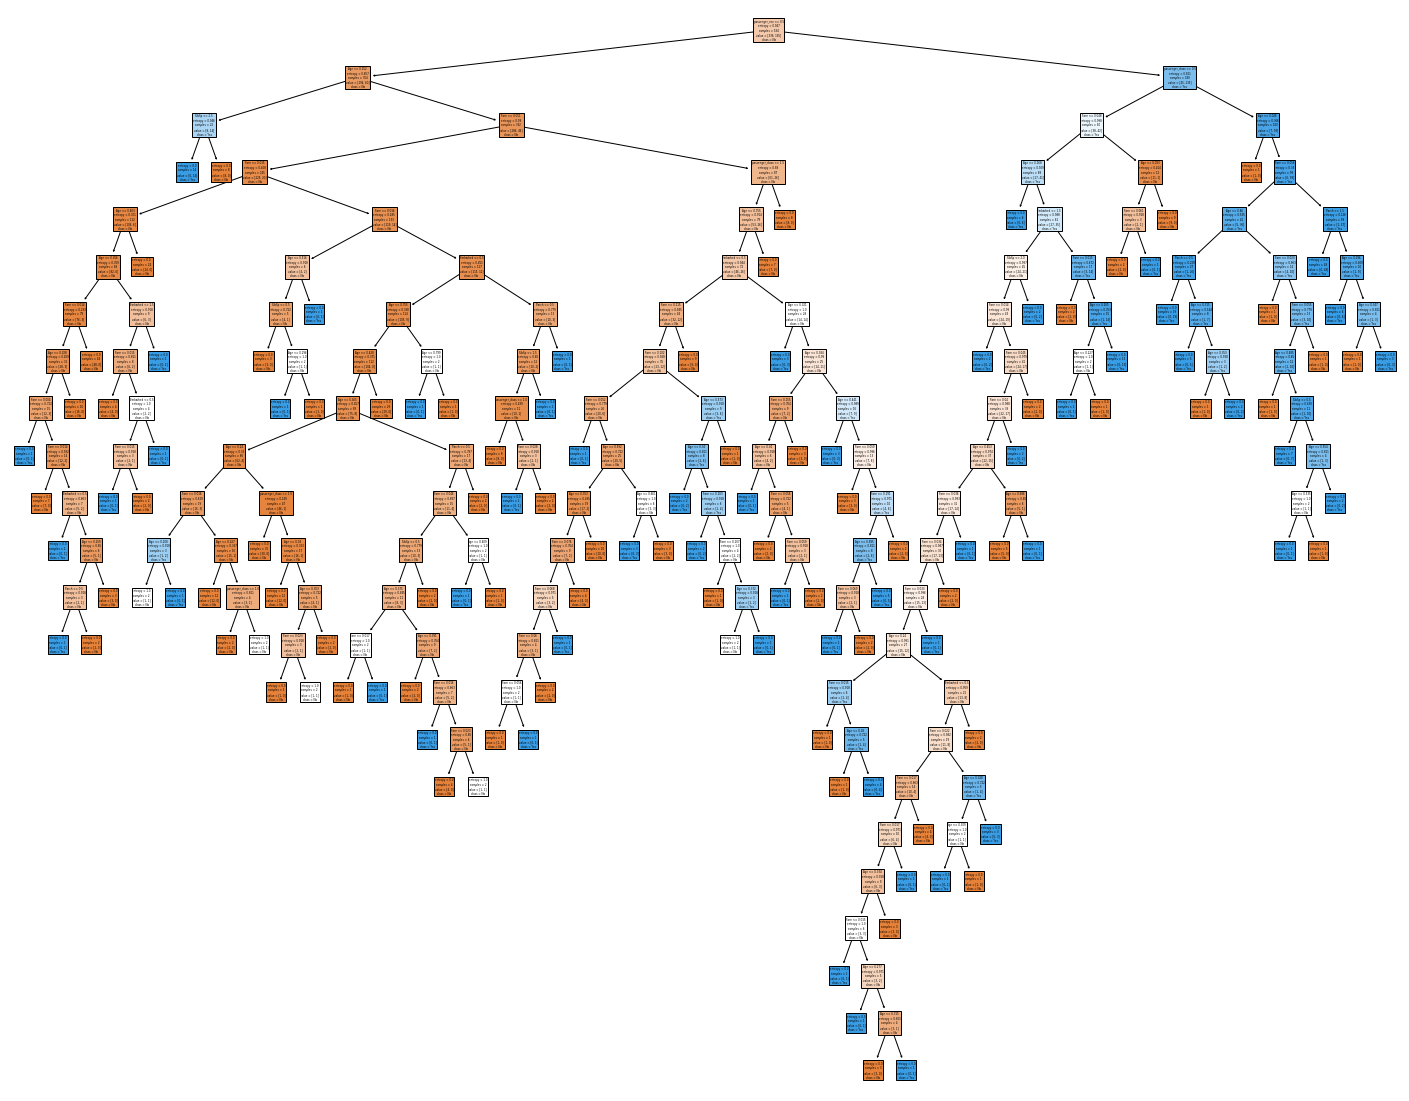

In [1960]:
feature_names = ['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex']
target_names = ['No','Yes']
#tree.plot_tree(dtc) 
#text_representation = tree.export_text(dtc)
#print(text_representation)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelo_DT.modelo, 
                   feature_names=feature_names,  
                   class_names=target_names,
                   filled=True)

### SVM

In [1516]:
class SVM_predict:
    def __init__(self,feature_names):
        self.modelo = None
        self.feature_names = feature_names
        
    def train(self, data,ylocal,ker='rbf',gam = 'scale',deg = 3):    
        svm_m = svm.SVC(probability = True,kernel= ker, gamma = gam, degree = deg)
        svm_m = svm_m.fit(data[self.feature_names], ylocal.values.ravel())
        self.modelo = svm_m
        return svm_m
        
    
    def predict(self, data):
        
        return self.modelo.predict(data[self.feature_names])



In [1958]:
fechaHora = datetime.now().strftime("%Y%m%d-%H%M%S")

#del x1e["survived"]
x2e
#x1train = x1e['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex','cat_edad']
feature_names = ['Age','SibSp','Parch','passenger_class','passenger_sex']



x2train = x2e#[feature_names]
y2train = y2e
xtest = x1v#[feature_names]
ytest = y1v

#kernel= linear, poly, rbf, sigmoid, precomputed
kernel = 'rbf'

# gamma = scale, auto
gamma = 'auto'

degree = 6

modelo_svm = SVM_predict(feature_names)

modelo_svm.train(x2train,y2train,kernel, gamma, degree)

#del x1v["survived"]
rt = modelo_svm.predict(xtest)

dump(modelo_svm.modelo, './github/svm_' + fechaHora + '_kernel=' + kernel + '_gamma=' + gamma + '_degree=' + str(degree) + '.joblib') 
#print(rt)
#rt_int = rt[:,1].astype(int)
#len(rt)
#rt_int
tn, fp, fn, tp = confusion_matrix(ytest['survived'].to_numpy(), rt ).ravel()
print(tn, fp, fn, tp)

precision,recall, fbeta_score, _  = precision_recall_fscore_support(ytest['survived'], rt, average='micro')
print(precision,recall, fbeta_score)
    
columnas = ",".join(feature_names)

resultado = np.array([fechaHora,kernel,gamma,
        tn, fp,fn,tp,
        precision,recall,fbeta_score,columnas
            ])
salida = pd.DataFrame(resultado).T
#print(salida.T)
salida.to_csv("./github/svm_salida.csv", mode='a', header=False)

91 15 24 48
0.7808988764044944 0.7808988764044944 0.7808988764044944


### Reg. logística 

##### Regularizacion por L2 y L1

Se agrego dentro de la fucion de costo

Solo se dejo **L1**, debido a que resulto ser la unica que aportaba dentro del modelo en base a las distintas ejecuciones

In [1926]:
class LogisticRegression:
    def __init__(self,clases,tipo):
        #tf.reset_default_graph()
        
        self.b = tf.Variable(tf.truncated_normal([clases, tipo]))

        self.biases = tf.Variable(tf.zeros([tipo]))
        self.error = tf.get_variable("error_total",dtype=tf.float32,
                                  shape=[],initializer=tf.zeros_initializer())
        self.prediccion = tf.get_variable("accuracy_total",dtype=tf.float32,
                                  shape=[],initializer=tf.zeros_initializer())

        
    def step(self,x,y,lr,reg):
        print(x,self.b)
        # hipotesis
        yhat = tf.add(tf.matmul(x, self.b, name="matmul"), self.biases,name="hipotesis")
        
        # loss
        # se agrega L2 a la funcion de costo
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = yhat,labels= y, name="sfmax_entropy")
                               #+ reg * tf.nn.l2_loss(self.b)
                               + reg * tf.math.reduce_sum(self.b)
                               ,name="total_entropy")
        # loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=tf_train_labels)) +
        # 0.01*tf.nn.l2_loss(hidden_weights) +
        # 0.01*tf.nn.l2_loss(out_weights) +
        
        
        # Optimizacion
        # optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
        grad = tf.gradients(error,[self.b,self.biases], name = "gradients")
        
        local_bn = tf.assign(self.b, self.b - tf.multiply(lr,grad[0],name="multi_lr_grad"), name="assign_beta")
        local_bias = tf.assign(self.biases, self.biases - tf.multiply(lr,grad[1],name="multi_lr_grad_bias"), name="assign_beta")
        local_error = tf.assign(self.error, error , name="assign_error")

        with tf.name_scope("accuracy") as scope:
            type_yhat = tf.math.argmax(yhat, 1, name="type_yhat")
            type_y = tf.math.argmax(y, 1, name="type_y")
            cant_ok = tf.reduce_sum(tf.cast(tf.math.equal(type_yhat,type_y), tf.float32), name = "correctos")
            total = tf.cast(tf.shape(y)[0],tf.float32, name = "total")
            local_pred = tf.assign(self.prediccion, (100.0 * cant_ok / total) , name = "asig_accuracy")
        #local_pred = tf.assign(self.prediccion,tf.shape(y))
        salida = tf.group(local_bn,local_bias,local_error, local_pred, name="grupo")

        return salida
    

In [1927]:
def playModel(xdat,ydat ,lr = 0.002, reg = 0.001,status = 50,batch_size = 32,epochs = 151 ):
    tf.reset_default_graph()
    cntClass = 2
    largo = len(xdat)
    shpData = xdat.shape
    columnas = shpData[1]
    iteraciones = int(largo/batch_size)
    gd = LogisticRegression(columnas,cntClass)

    xnpy = xdat.to_numpy() #.reshape(shpData[0],columnas)
    ynpy = pd.get_dummies(ydat['survived'], prefix='survived').to_numpy()
    dat_x = tf.placeholder(tf.float32,[None,columnas],"Value_x")
    dat_y = tf.placeholder(tf.float32,[None,cntClass],"Value_y")

    step = gd.step(dat_x,dat_y,lr, reg)

    error_summary = tf.summary.scalar('error_sum', gd.error)
    accu_summary = tf.summary.scalar('accuracy_sum', gd.prediccion)

    with tf.train.MonitoredSession() as session:
        localdir = "./github/logs_proyecto/LogReg_" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_reg=" + str(reg) + "_batch="+ str(batch_size) + "_ephocs=" + str(epochs)
        writer = tf.summary.FileWriter(localdir , session.graph)

        for i in range(epochs):

            for j in range(iteraciones):
                inicio = j * batch_size
                fin = inicio + batch_size
                feed = {dat_x:xnpy[inicio:fin], dat_y:ynpy[inicio:fin]}
                session.run(step,feed_dict=feed)
            esummary ,asummary = session.run([error_summary,accu_summary],feed_dict=feed)
            writer.add_summary(esummary, i)
            writer.add_summary(asummary, i)
                
            feed = {dat_x:xnpy, dat_y:ynpy}
            session.run(step,feed_dict=feed)
            summary = session.run(error_summary,feed_dict=feed)
            if i%status ==0:
                error,pred = session.run([gd.error,gd.prediccion],feed_dict=feed)
                print('epochs',i)
                print("error = {}; accuracy = {}".format(error,pred))


        b,bias,error,pred = session.run([gd.b,gd.biases,gd.error,gd.prediccion],feed_dict=feed)
        #print("y = {} {}".format(b,bias))
        print("error = {}; accuracy = {}".format(error,pred))
    return (b,bias)

In [1928]:
class LR_predict:
    def __init__(self,feature_names,b, bias):
        self.modelo = None
        self.feature_names = feature_names
        self.b = b
        self.bias = bias
        
       
    
    def predict(self, data):
        local = data[self.feature_names].to_numpy()
        # calcula los valores (logits) de cada clase
        y_teorico = np.matmul(local, self.b) + self.bias

        # a los logits se pasan por argmax y se selecciona el indice con mayor valor
        seleccion = np.argmax(softmax(y_teorico), axis=1)
        #seleccion
        return seleccion


In [1929]:
fechaHora = datetime.now().strftime("%Y%m%d-%H%M%S")

#del x1e["survived"]

#x1train = x1e['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex','cat_edad']
feature_names = ['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex']



x4train = x4e[feature_names]
y4train = y4e
xtest = x4v#[feature_names].to_numpy()
ytest = y4v

reg = 0.005
lr = 0.015
batch_size = 34
epochs = 2001
status = 500
orig_b, original_bias = playModel(x4train,y4train, lr, reg, status, batch_size, epochs)


cols = orig_b.shape[0]
modelo = pd.DataFrame({
    'vars': [cols],
    'b':[orig_b.reshape(cols * 2,1)],
    'bias': [original_bias.reshape(2,1) ]
})
#.reshape(orig_b.shape[0]*2,1)
modelo.to_csv('./github/modelos_lg_' + datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_reg=" + str(reg) + "_batch="+ str(batch_size) + "_ephocs=" + str(epochs) + '.csv', header=False)

modelo_lr = LR_predict(feature_names,orig_b, original_bias)
seleccion = modelo_lr.predict(xtest)

# calcula los valores (logits) de cada clase
#y_teorico = np.matmul(xtest, orig_b) + original_bias

# a los logits se pasan por argmax y se selecciona el indice con mayor valor
#seleccion = np.argmax(softmax(y_teorico), axis=1)
#seleccion

columnas = ",".join(feature_names)

tn, fp, fn, tp = confusion_matrix(ytest['survived'], seleccion).ravel()
print(tn, fp, fn, tp)

precision,recall, fbeta_score, _  = precision_recall_fscore_support(ytest['survived'], seleccion, average='micro')
print(pres,rec, fbe)

#Resultado del modelo
resultado = np.array([fechaHora,lr,batch_size, epochs,
        tn, fp,fn,tp,
        precision,recall,fbeta_score,columnas
            ])
salida = pd.DataFrame(resultado).T
#print(salida.T)
salida.to_csv("./github/lg_salida.csv", mode='a', header=False)




Tensor("Value_x:0", shape=(?, 7), dtype=float32) <tf.Variable 'Variable:0' shape=(7, 2) dtype=float32_ref>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
epochs 0
error = 0.6133424043655396; accuracy = 68.72659301757812
epochs 500
error = 0.38916051387786865; accuracy = 82.95880126953125
epochs 1000
error = 0.34491199254989624; accuracy = 82.95880126953125
epochs 1500
error = 0.30148813128471375; accuracy = 82.58426666259766
epochs 2000
error = 0.25853419303894043; accuracy = 82.58426666259766
error = 0.25853419303894043; accuracy = 82.58426666259766
98 19 24 37
0.7752808988764045 0.7752808988764045 0.7752808988764045


<img src="proyecto_error.png" width="1000px">
<img src="proyecto_modelo.png" width="1000px">

### Ensamble

In [1931]:
modelos = [modeloNB,modelo_DT,modelo_svm,modelo_lr]


In [1932]:
def predict_ensable(nm, xDat):
    ypred = []
    for m in nm:
        ypred.append(m.predict(xDat)[0])
    conteo = stats.mode(ypred)
    ypred.append(conteo[1][0])
    ypred.append(conteo[0][0])
    return ypred

In [1954]:
dat_ensamble = []
valores = np.random.randint(1,890, size=20)

for i in valores:
    t = predict_ensable(modelos,base_data[i:i+1])
    # valor real
    t.append(base_data[i:i+1]['survived'].to_numpy()[0])
    #print()
    dat_ensamble.append(t)
r_df = pd.DataFrame(dat_ensamble,columns=['Modelo NB','Modelo D Tree','Modelo SVM', 'Modelo LR','Count','Ensable','Real'])


### Pruebas y evaluaciones

In [1946]:
r_df

,Modelo NB,Modelo D Tree,Modelo SVM,Modelo LR,Count,Ensable,Real
0,0,0,0,0,4,0,0
1,0,0,0,0,4,0,0
2,1,0,1,1,3,1,1
3,1,1,1,1,4,1,1
4,0,0,0,0,4,0,0
5,1,1,0,0,2,0,1
6,0,0,0,0,4,0,0
7,0,0,0,0,4,0,0
8,1,1,1,1,4,1,0
9,1,1,1,1,4,1,1


In [1953]:
tn, fp, fn, tp = confusion_matrix(r_df['Real'], r_df['Ensable']).ravel()
print(tn, fp, fn, tp)

precision = tp / (tp + fp)
recall = tp / (tp + fn)
F = (2 * precision * recall) / (precision + recall)
print ('Precision: {} '.format(precision*100)  )
print ('Recall: {} '.format(recall*100)  )
print ('F1: {} '.format(F*100)  )



9 0 1 10
Precision: 100.0 
Recall: 90.9090909090909 
F1: 95.23809523809523 


### Conclusiones

Algunos resultados no fueron los esperados, el uso de k-folds podria ayudar a mejorar el desempeño de algunso algoritmos.  La implementacion de Naive Bayes de forma manual resulto laboriosa y fue lo que tomo mas tiempo y sin duda alguna se puede mejorar con otro enfoque.


En distintas ejecuciones aleatorias se logra obtener un buen resultado, pero en varios casos sale un empate ya que 2 modelos dicen una cosa contraria que el resto.  Tal vez un 5 modelo distinto podria desempatar y evitar que se asigne aleatoriamente el valor teniendo un 50% de acierto.  


La seleccion de muestras independientes ayuda a que los modelos se basen en distintos datos y aprendan de forma diferente entre ellos para lograr errores que puedan tener en si mismos


Con la combinacion de los modelos en varias ociaciones se logran resultados similares al siguiente, aunque como este resultado toma datos del mismo modelo no podriamos considerarla tan confiable
* Precision: 81.82 %
* Recall: 100 %
* F1: 90.0 %

Debido a que la formula de Precision y Recall favorecen a los *True Positive* resulta ser una metrica *desfaborable* por que la mayoria de los datos en este caso son 0 desde la perspectiva de si sobrevivio la persona.  Si se evalua de que los 0 son true positive aumenta significativamente todos los resultados.  Esto es debido a que los datos estan desbalanceados entre 0s y 1s.

La distribucion de sobrevivientes es aprox 1/3 por lo que a pesar que se acierten muchos True Negative, los True Positive seran la mitad en proporcion.

Algunos metodos presentan mejor rendimiento que otros y forma de estructurar el uso de los datos afecta significativamente dentro de los resultados finales

Recomendaciones:


A pesar que el proyecto de dejo desde el inicio del curso, resulta ser confuso ya que no se ha visto nada de lo que es necesario realizar; pareciaba haber mucho tiempo pero incluso el ultimo dia de clases aun se tocaron temas relevantes para el desarrollo del proyecto... tal vez se podria estructurar de tal forma que al llegar a determianda etapa del curso se pueda decir: "con este contenido ya se puede realizar la primer parte del proyecto" y asi sucesivamente.  


Bajo esta misma linea se podria estructurar el contenido para ese mismo fin, por ejemplo adelantar el contenido de ensable, bootstraping, etc.  O que el proyecto conteple un contenido hasta el 75% del curso y la ultima parte cubrirla con otro tipo de asignaciones... 


Al final el proyecto si fue interesante y desafiante con un tiempo muy corto

#### Carga de modelos

<a href="" target="_blank">Notebook de carga de modelos</a>